In [ ]:
import torch.nn as nn
import functools
import torch
import numpy as np
from matplotlib import pyplot as plt
import numba_scipy
import gc
import os
from utils import save_checkpoint_withEval as save_checkpoint
from utils import restore_checkpoint_withEval as restore_checkpoint
import datasets
import tensorflow as tf
from torch.utils.cpp_extension import load
from models import ncsnpp
from configs.vp import cifar10_ncsnpp_continuous as configLoader
from models import utils as mutils
from models.ema import ExponentialMovingAverage

In [ ]:
relu = nn.functional.relu

### Loading the ML model from Song et al.

In [ ]:
config =  configLoader.get_config()
config.training.batch_size=128
config.training.snapshot_freq_for_preemption=1000
config.training.snapshot_freq=50000
config.training.log_freq=5

In [ ]:
config.data.dataset='MNIST'
config.data.image_size=32
config.data.num_channels=3
config.data.random_flip=False
config.model.nf=64
config.model.name='ncsnpp'
config.model.num_scales=1000

### Specify observation times

In [ ]:
tEnd = 15. #(approximately)
T = 1000
T = T+1
observationTimes1 = np.linspace(0, 1, 201)[1:]
observationTimes2 = np.linspace(1, tEnd, 801)[1:]
observationTimes = np.hstack((observationTimes1,observationTimes2))
T = T-1

### Load the trained model

In [ ]:
score_model = mutils.create_model(config)
score_fn = mutils.get_model_fn(score_model, train=True)
optimizer = torch.optim.Adam(score_model.parameters(),lr=config.optim.lr) 
ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=score_model, ema=ema, lossHistory=[], step=0)

workdir = 'linearDegradation-mnist'

checkpoint_dir = os.path.join(workdir, "checkpoints")
checkpoint_meta_dir = os.path.join(workdir, "checkpoints-meta", "checkpoint.pth")
tf.io.gfile.makedirs(checkpoint_dir)
tf.io.gfile.makedirs(os.path.dirname(checkpoint_meta_dir))
state = restore_checkpoint(checkpoint_meta_dir, state, config.device)
initial_step = int(state['step'])
lossHistory = state['lossHistory']
evalLossHistory = state['evalLossHistory']
ema.copy_to(score_model.parameters())

### Visualize train/test loss

In [ ]:
def emaFunc(x, r):
    
    output = np.zeros_like(x)
    
    output[0] = x[0]
    
    for i in range(1, len(x)):
        
        output[i] = (1.0-r)*output[i-1] + (r)*x[i]
        
    return output

Text(0.5, 1.0, 'Iteration=61')

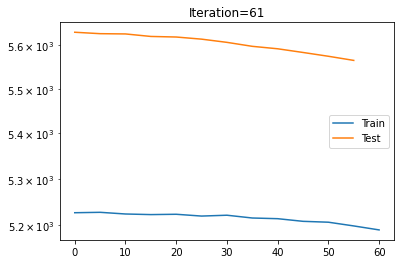

In [19]:
fig = plt.figure()
plt.plot(5*np.arange(len(lossHistory[::5][:])), np.array(emaFunc(lossHistory[::5][:],0.01)), label='Train')
plt.plot(5*np.arange(len(evalLossHistory[:])), np.array(emaFunc(evalLossHistory[:], 0.01)), label='Test')
plt.gca().set_yscale('log')
plt.legend(loc='best')
plt.title(f'Iteration={len(lossHistory)}')

### Generating samples

In [ ]:
# Tau-leaping

ensN = 64

state = torch.from_numpy(0.*np.ones((ensN,3,32,32)).astype('float32')).to(config.device)

summary = []

with torch.no_grad():
    
    for i in range(T-1, -1, -1):

        if np.mod(i,50)==0:
            
            print(f'reverse pass, tIndex={i}, t={observationTimes[i]}')
            
        p = np.exp(-observationTimes[i])
        
        width = 255.0/2*p
        mean_v = 255.0/2*p
        
        ind = torch.from_numpy(i*np.ones((ensN,)).astype('int32')).to(config.device)
        birthRate = relu(score_fn((state-mean_v)/width, ind)).detach().cpu().numpy()*p/(1-p)
        
        if i==0:
            dt = observationTimes[i]
        else:
            dt = observationTimes[i]-observationTimes[i-1]
             
        draw = np.random.poisson(dt*birthRate)
        
        summary.append(np.ravel(draw))
        
        state = torch.clip(state + torch.from_numpy((draw).astype('float32')).to(config.device), 0, 255)

In [ ]:
factor = ensN //64

fig,ax=plt.subplots(8*factor,8,figsize=(12,10*factor))

for i in range(8*factor):
    for j in range(8):
        ax[i,j].imshow( np.transpose(state[8*i+j,:,:,:].detach().cpu().numpy(), [1,2,0])/255 )
        ax[i,j].set_title(str(8*i+j))
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])

fig.tight_layout()